# Laboratorio 6 – Redes Generativas
## Adversariales (GANs)
## Objetivo del laboratorio
Implementar y entrenar una Red Generativa Adversarial utilizando datos de imágenes reales, con
el fin de generar imágenes artificiales que imiten la distribución de los datos originales.
Contexto de la vida real: Generación de rostros de personas
Se utilizará el conjunto de datos CelebA, imágenes de rostros de celebridades (debidamente
anonimizadas). El objetivo es que puedan entrenar una GAN para generar rostros que parezcan
realistas.
Nota: Este conjunto de datos consta de más de 200,000 imágenes a color, de 128 X 128 X 3 c/u.
Se puede descargar del sitio de Kaggle, específicamente del enlace:
* https://www.kaggle.com/datasets/jessicali9530/celeba-dataset

Se tomo referencia de esta implementación simple de GAN
* https://www.kaggle.com/code/ashishpatel26/gan-beginner-tutorial-for-pytorch-celeba-dataset/notebook


In [30]:
import torch, os
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.datasets as dset
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder


# 1. Preparación de los datos (20 puntos)
- Carga correcta del conjunto de datos: 5 puntos
- Preprocesamiento adecuado: 15 puntos

In [19]:
lr = 0.0002
max_epoch = 3
batch_size = 32
z_dim = 100
image_size = 64
g_conv_dim = 64
d_conv_dim = 64
log_step = 100
sample_step = 500
sample_num = 32
IMAGE_PATH = r'C:\Users\charl\Desktop\S22023\DataScience\Laboratorio8\archive\img_align_celeba'
SAMPLE_PATH = '../'

if not os.path.exists(SAMPLE_PATH):
    os.makedirs(SAMPLE_PATH)

In [20]:
transform = transforms.Compose([
    # transforms.Scale(image_size),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageFolder(IMAGE_PATH, transform)
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)

# 2. Implementación de la GAN (50 puntos)
- Diseño correcto del generador: 15 puntos
- Diseño correcto del discriminador: 15 puntos
- Definición adecuada de funciones de pérdida y optimizadores: 20 puntos

In [21]:
def conv(ch_in, ch_out, k_size, stride=2, pad=1, bn=True):
    layers = []
    layers.append(nn.Conv2d(ch_in, ch_out, k_size, stride, pad))
    if bn:
        layers.append(nn.BatchNorm2d(ch_out))
    return nn.Sequential(*layers)


class Discriminator(nn.Module):
    def __init__(self, image_size=128, conv_dim=64):
        super(Discriminator, self).__init__()
        self.conv1 = conv(3, conv_dim, 4, bn=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        self.fc = conv(conv_dim*8, 1, int(image_size/16), 1, 0, False)
        
    def forward(self, x):                           
        out = F.leaky_relu(self.conv1(x), 0.05)       
        out = F.leaky_relu(self.conv2(out), 0.05)
        out = F.leaky_relu(self.conv3(out), 0.05)
        out = F.leaky_relu(self.conv4(out), 0.05)
        out = F.sigmoid(self.fc(out)).squeeze()
        return out
    
D = Discriminator(image_size)
D.cpu()
# D.cpu()

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [22]:
def deconv(ch_in, ch_out, k_size, stride=2, pad=1, bn=True):
    layers = []
    layers.append(nn.ConvTranspose2d(ch_in, ch_out, k_size, stride, pad))
    if bn:
        layers.append(nn.BatchNorm2d(ch_out))
    return nn.Sequential(*layers)

class Generator(nn.Module):
    def __init__(self, z_dim=256, image_size=128, conv_dim=64):
        super(Generator, self).__init__()
        self.fc = deconv(z_dim, conv_dim*8, int(image_size/16), 1, 0, bn=False)
        self.deconv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.deconv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv3 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv4 = deconv(conv_dim, 3, 4, bn=False)
        
    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        out = self.fc(z)
        out = F.leaky_relu(self.deconv1(out), 0.05)
        out = F.leaky_relu(self.deconv2(out), 0.05)
        out = F.leaky_relu(self.deconv3(out), 0.05)
        out = F.tanh(self.deconv4(out))
        return out
    
G = Generator(z_dim, image_size, g_conv_dim)
G.cpu()

Generator(
  (fc): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv4): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [23]:
criterion = nn.BCELoss().cpu()
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

In [24]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [25]:
try:
    G.load_state_dict(torch.load('generator.pkl'))
    D.load_state_dict(torch.load('discriminator.pkl'))
    print("\n-------------model restored-------------\n")
except:
    print("\n-------------model not restored-------------\n")
    pass


-------------model not restored-------------



# 3. Entrenamiento de la GAN (25 puntos)
- Implementación correcta de la iteración de entrenamiento: 15 puntos

In [26]:
total_batch = len(data_loader.dataset)//batch_size
fixed_z = Variable(torch.randn(sample_num, z_dim)).cpu()
for epoch in range(max_epoch):
    for i, (images, labels) in enumerate(data_loader):

        image = Variable(images).cpu()
        real_labels = Variable(torch.ones(batch_size)).cpu()
        fake_labels = Variable(torch.zeros(batch_size)).cpu()

        outputs = D(image)
        d_loss_real = criterion(outputs, real_labels) # BCE
        real_score = outputs
        
        z = Variable(torch.randn(batch_size, z_dim)).cpu()
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels) #BCE
        fake_score = outputs
        
        d_loss = d_loss_real + d_loss_fake
        D.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        z = Variable(torch.randn(batch_size, z_dim)).cpu()
        fake_images = G(z)
        outputs = D(fake_images)
        
        g_loss = criterion(outputs, real_labels)
        D.zero_grad()
        G.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i + 1) % log_step == 0:
            print("Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, D(x): %.2f, D(G(z)): %.2f" % (
                epoch, max_epoch, i + 1, total_batch, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))

    
        if(i+1)%sample_step == 0:
            fake_images = G(fixed_z)
            torchvision.utils.save_image(denorm(fake_images.data), os.path.join(SAMPLE_PATH, 'fake_samples-%d-%d.png')%(
            epoch+1, i+1), nrow=8)
            
torch.save(G.state_dict(), 'generator.pkl')
torch.save(D.state_dict(), 'discriminator.pkl')

Epoch [0/3], Step[100/6331], d_loss: 0.0025, g_loss: 7.8970, D(x): 1.00, D(G(z)): 0.00
Epoch [0/3], Step[200/6331], d_loss: 0.0006, g_loss: 8.4199, D(x): 1.00, D(G(z)): 0.00
Epoch [0/3], Step[300/6331], d_loss: 0.0004, g_loss: 8.7470, D(x): 1.00, D(G(z)): 0.00
Epoch [0/3], Step[400/6331], d_loss: 0.0002, g_loss: 9.3079, D(x): 1.00, D(G(z)): 0.00
Epoch [0/3], Step[500/6331], d_loss: 0.0001, g_loss: 9.4592, D(x): 1.00, D(G(z)): 0.00
Epoch [0/3], Step[600/6331], d_loss: 0.0001, g_loss: 10.1264, D(x): 1.00, D(G(z)): 0.00
Epoch [0/3], Step[700/6331], d_loss: 0.0001, g_loss: 10.2452, D(x): 1.00, D(G(z)): 0.00
Epoch [0/3], Step[800/6331], d_loss: 0.0001, g_loss: 10.0369, D(x): 1.00, D(G(z)): 0.00
Epoch [0/3], Step[900/6331], d_loss: 0.0000, g_loss: 10.2701, D(x): 1.00, D(G(z)): 0.00
Epoch [0/3], Step[1000/6331], d_loss: 0.0000, g_loss: 10.7346, D(x): 1.00, D(G(z)): 0.00
Epoch [0/3], Step[1100/6331], d_loss: 0.0000, g_loss: 10.7834, D(x): 1.00, D(G(z)): 0.00
Epoch [0/3], Step[1200/6331], d_los

- Visualización adecuada de los resultados: 10 puntos

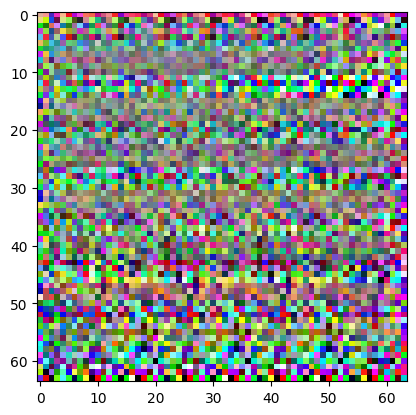

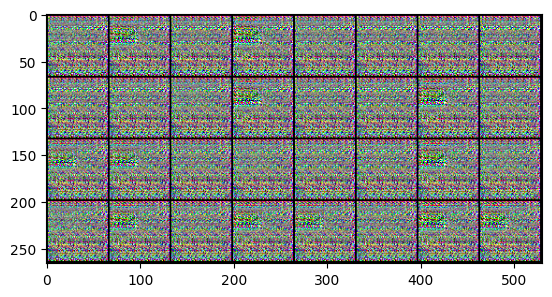

C:\Users\charl\AppData\Local\Temp\ipykernel_54204\1631677860.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_name))


epoch : 1, step : 500
epoch : 1, step : 1000
epoch : 1, step : 1500
epoch : 1, step : 2000
epoch : 1, step : 2500
epoch : 1, step : 3000
epoch : 1, step : 3500
epoch : 1, step : 4000
epoch : 1, step : 4500
epoch : 1, step : 5000
epoch : 1, step : 5500
epoch : 1, step : 6000
epoch : 2, step : 500
epoch : 2, step : 1000
epoch : 2, step : 1500
epoch : 2, step : 2000
epoch : 2, step : 2500
epoch : 2, step : 3000
epoch : 2, step : 3500
epoch : 2, step : 4000
epoch : 2, step : 4500
epoch : 2, step : 5000
epoch : 2, step : 5500
epoch : 2, step : 6000
epoch : 3, step : 500
epoch : 3, step : 1000
epoch : 3, step : 1500
epoch : 3, step : 2000
epoch : 3, step : 2500
epoch : 3, step : 3000
epoch : 3, step : 3500
epoch : 3, step : 4000
epoch : 3, step : 4500
epoch : 3, step : 5000
epoch : 3, step : 5500
epoch : 3, step : 6000


In [31]:
fixed_z = Variable(torch.randn(sample_num, z_dim)).cpu()
fake_images = G(fixed_z)
plt.imshow(denorm(fake_images[0].cpu().permute(1, 2, 0).data).numpy())
plt.show()

plt.imshow(make_grid(denorm(fake_images).data.cpu()).permute(1, 2, 0).numpy())
plt.show()

import imageio

images = []
for epoch in range(max_epoch):
    for i in range(total_batch):
        if(i+1)%sample_step == 0:
            img_name = '../fake_samples-' + str(epoch + 1) + '-' + str(i + 1) + '.png'
            images.append(imageio.imread(img_name))
            print("epoch : {}, step : {}".format(epoch+1, i+1))
imageio.mimsave('dcgan_celebA_generation_animation.gif', images, duration=200)

# 4. Reflexión (5 puntos)
- Reflexión sobre conceptos teóricos y conexión con el laboratorio: 2 puntos
- Identificación de aplicaciones y potencial de las GANs: 1 punto
- Reconocimiento de limitaciones y preocupaciones éticas: 1 punto
- Claridad y coherencia en la escritura: 1 punto


La teoría de las GANs presenta desafíos significativos debido a su complejidad y la necesidad de comprender la dinámica competitiva entre el generador y el discriminador. Nuestro trabajo en el laboratorio resultó fundamental para solidificar estos conceptos, ya que nos brindó la oportunidad de experimentar directamente con la implementación y el entrenamiento de una GAN. Durante este proceso, pudimos vislumbrar un potencial considerable para las GANs en diversas aplicaciones industriales, como la generación de contenido multimedia y la ampliación de conjuntos de datos.

Sin embargo, también somos conscientes de las limitaciones éticas asociadas a las GANs, como la posibilidad de generar información falsa o sesgada. A medida que profundizamos en esta experiencia práctica, hemos adquirido una mayor confianza en la implementación y el entrenamiento de GANs. No obstante, mantenemos firmemente en mente la importancia de que su uso se guíe por consideraciones éticas y una responsabilidad sólida. Esto asegurará que las GANs se utilicen de manera ética y para beneficio de la sociedad en general.